# __Otimização dos hyperparametros com Keras Tuner__
- Dataset: Guarujá (cap. 2)

##### Copyright 2021 Caio Azevedo - ensaios de uma dissertação. 

15 de julho de 2021 - última atualização __todo santo dia__
- ref. https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref. https://www.tensorflow.org/tutorials/structured_data/feature_columns

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/cazevedo1977/dissertacao">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    Projeto completo no GitHub</a>
  </td>
  
</table>

Este tutorial demonstra como classificar dados estruturados (por exemplo, dados tabulares em um CSV). Utilizamos a biblioteca  [Keras](https://www.tensorflow.org/guide/keras) para definir o modelo e [camadas de pré-processamento](https://www.tensorflow.org/guide/keras/preprocessing_layers) como uma ponte para mapear as colunas de um CSV para features usadas para treinar o modelo. As principais funcionalidades da implementação são:

* Carregar um arquivo CSV usando [Pandas](https://pandas.pydata.org/).
* Construir um pipeline de entrada para criar lotes e 'embaralhar' as linhas de dados [tf.data](https://www.tensorflow.org/guide/datasets).
* Mapear as colunas do CSV para features utilizadas para treinar o modelo usando camadas de pré-processamento Keras.
* Identificar os melhores hyperparâmetros para rede usando [keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
* Construir, treinar e avaliar o modelo usando Keras Build.

## O Dataset

O estudo de caso consiste em elaborar um mapa de suscetibilidade mediante um trabalho de campo com dados provenientes do IPT e da Defesa Civil em uma área monitorada no município do Guarujá, região metropolitana da baixada santista no estado de São Paulo. 

As áreas de suscetibilidade são identificadas considerando os fatores de influência disponibilizados pelo IPT, que devem estar entre aquelas apontadas na literatura como as mais utilizadas e de melhor desempenho, tais como:  declividade, litologia, elevação, curvatura do plano, uso do solo, aspecto, distância às estradas, distância ao rio, curvatura do perfil, índice de umidade topográfico, distância às falhas. 

Para fins desse estudo, serão analisados escorregamentos do tipo planar raso, previamente definidos e caracterizados na revisão de literatura. 

A seguir temos a descrição desse conjunto de dados. Percebe-se a presença de dados categoricos e numéricos. A variável target  é chamada class e identifica a ocorrência de escorregamentos.
							

Coluna | Descrição | Feature Type | Data Type
------------|--------------------|----------------------|-----------------
slope | ângulo de inclinação da encosta | Numérico | float
aspect |  Age of the pet | Numérico | float
elevation | altitudes presentes na região | Numérico | float
uso_solo | 10 = Mata, 20 = Campo antrópico; 30 = Área urbana; 40 = Mangue (Guarujá) | Categórico | integer
lito | ou geologia, composição do solo 2 = ?, 65 = ?? (Guarujá) | Categórico | integer
twi | medida teórica do acúmulo de fluxo e, portanto, da umidade do solo | Numérico | float
curv | definido como a taxa de mudança do ângulo de inclinação com o plano da superfície | Categórico | float
class | ocorrência de escorregamento | Categórico | integer

## TensorFlow e outras bibliotecas


In [1]:
#!pip install -q sklearn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
tf.__version__

'2.5.0'

## Pandas para criação do dataframe

[Pandas](https://pandas.pydata.org/) é uma biblioteca Python com muitas utilidades para carregar e trabalhar com dados estruturados. Aqui ele será utilizado disponibilizado pelo IPT em um arquivo csv e carregá-lo em um dataframe.

In [4]:
import pathlib
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
APP_PATH = os.getcwd()
#csv_file = 'data/Input_POA.csv'

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

#file = "Input_Guaruja_revisado_3_shuffled.csv"
dataframe = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

In [5]:
dataframe.head(5)

,FID,x,y,TWI,Curvatura,Declividade,Elevacao,Aspecto,Geologia,Uso,class
0,41,369620.5068,7341768.941,4.986568,0.004039,25.549398,125.138084,265.600525,2,90,0
1,35,377987.9715,7346729.888,3.591059,-0.002693,28.871576,20.844248,210.925430,2,90,0
2,196,379740.3229,7357240.187,6.682012,-0.008088,11.338614,5.026316,0.304541,65,90,1
3,126,373367.0000,7347570.000,2.954426,-0.007107,27.523371,53.852108,148.607895,2,90,1
4,194,379331.1667,7356869.344,5.457664,0.004764,27.095221,20.934837,334.631256,65,90,1


In [6]:
dataframe.rename(columns={'TWI': 'twi','Curvatura': 'curv', 'Declividade': 'slope','Elevacao': 'elevation','Aspecto': 'aspect', 'Geologia': 'lito', 'Uso': 'uso_solo'}, inplace=True)
dataframe = dataframe[['slope','aspect','elevation','uso_solo','lito','twi','curv','class']]
dataframe.head(5)

,slope,aspect,elevation,uso_solo,lito,twi,curv,class
0,25.549398,265.600525,125.138084,90,2,4.986568,0.004039,0
1,28.871576,210.925430,20.844248,90,2,3.591059,-0.002693,0
2,11.338614,0.304541,5.026316,90,65,6.682012,-0.008088,1
3,27.523371,148.607895,53.852108,90,2,2.954426,-0.007107,1
4,27.095221,334.631256,20.934837,90,65,5.457664,0.004764,1


In [7]:
#Experimento para testar a performance do modelo lidando com os dados categoricos com OneHotEncoder string ou numérico
#dataframe['lito'] = dataframe['lito'].astype(str)
#dataframe['uso_solo'] = dataframe['uso_solo'].astype(str)

## Preparação dos dados (Remoção das features irrelevantes & Normalização)
__Cuidado com data leakage, considerar as melhores práticas:__
- Train-Test Evaluation With Correct Data Preparation
- Data Preparation With k-fold Cross-Validation

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/
ref. https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
ref. https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
ref. https://www.section.io/engineering-education/data-leakage/
ref. https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1

 __Segue abaixo, a ordem de relevância das das variáveis, bem como a identificação daquelas que podem ser removidas da análise.__
  - elevation | elevation (ok) 
  - uso_solo | uso_solo (ok)
  - twi | curvatura (ok)
  - curvatura | twi (ok)
  - lito | aspect   __(to be tested)__
  - aspect | lito   __(to be tested)__
  - slope | slope   __(to be tested)__

In [8]:
#POA
#dataframe = dataframe.drop('lito',axis=1)
#dataframe = dataframe.drop('curv',axis=1)
#dataframe = dataframe.drop('aspect',axis=1)
# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset

#Guarujá
#dataframe = dataframe.drop('lito',axis=1)
#dataframe = dataframe.drop('slope',axis=1)
#dataframe = dataframe.drop('aspect',axis=1)
#dataframe.head(5)

## Dividir o dataframe em treinamento, validação e teste

O dataset será dividido em conjuntos de treinamento, validação e teste.

In [9]:
train, test = train_test_split(dataframe, test_size=0.3)
train, val = train_test_split(train, test_size=0.3)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

96 train examples
42 validation examples
60 test examples


## Criar um pipeline de entrada usando tf.data

A seguir, manipular os dataframes com [tf.data](https://www.tensorflow.org/guide/datasets), a fim de embaralhar e criar lotes de dados.

In [10]:
# método para criação de um tf.data dataset apartir do] Dataframe pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=5):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

Como o pipeline de entrada criado, hora de ver o formato dos dados que ele retorna. Um tamanho de lote pequeno mantém a saída de dados legível.

In [11]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [12]:
[(train_features, label_batch)] = train_ds.take(1) #visto que criamos lotes de 5, cada take retorna por lote
print('Todas as feature:', list(train_features.keys()))
print('Um lote de twi:', train_features['twi'])
print('Um lote de targets:', label_batch )

Todas as feature: ['slope', 'aspect', 'elevation', 'uso_solo', 'lito', 'twi', 'curv']
Um lote de twi: tf.Tensor([ 7.48505354  8.95977974 11.97548389  9.61182022  6.30506802], shape=(5,), dtype=float64)
Um lote de targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


Percebe-se que o dataset retorna um dicionário de nomes de coluna (do dataframe) que mapeia para valores de coluna de linhas no dataframe.

## Demonstre o uso de camadas de pré-processamento..

A API de camadas de pré-processamento do Keras permite que se crie pipelines de processamento de entrada nativos Keras. Aqui utilizamos 3 camadas de pré-processamento para demonstrar o código de pré-processamento das features.

*   [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) - normalização dos dados.
*   [`CategoryEncoding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/CategoryEncoding) -  camada de codificação de dados categoricos.
*   [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/StringLookup) - Mapeamento de features do tipo string para índices inteiros.
*   [`IntegerLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/IntegerLookup) - Mapeamento de features do tipo inteiro para índices inteiros.

lista de camadas de pré-processamento disponíveis [aqui](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing).




### Colunas Numéricas
Para cada feature numérica, é feita a normalização dos dados para garantir que todas estejam na mesma escala, aqui adotamos média 0 e desvio padrão 1.

`get_normalization_layer` função que retorna os valores dos dados devidamente normalizados.

In [13]:
def get_normalization_layer(name, dataset):
  # Cria uma camada de normalização para as features.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepara o Dataset 
  feature_ds = dataset.map(lambda x, y: x[name])

  normalizer.adapt(feature_ds)

  return normalizer

In [14]:
count_col = train_features['twi']
layer = get_normalization_layer('twi', train_ds)
layer(count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.0801373 ],
       [ 0.5396736 ],
       [ 1.4793909 ],
       [ 0.7428546 ],
       [-0.28755552]], dtype=float32)>

### Colunas categoricas
Nesse dataset, as variáveis categoricas são representadas como inteiros ('lito' e 'uso_solo'). Optamos por testar essas variáveis com ou sem esse tratamento. Se tivessemos categoricos do tipo string, eles não poderiam ser inseridas diretamente no modelo. A camada de preprocessamento deveria tratá-las antes as transformando em vetores do tipo one-hot.

`get_category_encoding_layer` função que retorna uma camada que mapeia valores de variáveis na forma one-hot encodes.

In [15]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Cria uma camada StringLookup que transforma features strings em indices inteiros (se necessário)
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # seleciona as features que serão transformadas
  feature_ds = dataset.map(lambda x, y: x[name])

  index.adapt(feature_ds)

  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  #Aplica one-hot encoding para os indices mapeados. A função lambda captura a feature  
  #que será convertida
  return lambda feature: encoder(index(feature))

Como demostração da função, eis o tratamento da feature usuo_solo.

In [16]:
type_col = train_features['uso_solo']
layer = get_category_encoding_layer('uso_solo', train_ds, dtype='int64')
layer(type_col)

<tf.Tensor: shape=(5, 9), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

Criação do pipeline de entrada em batch.

In [17]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [18]:
all_inputs = []
encoded_features = []

#features numericas

#Todas
for header in ['slope', 'aspect','elevation','twi','curv','lito', 'uso_solo']:

#guaruja sem categoricas
#for header in ['slope', 'aspect','elevation','twi','curv']:
#guaruja relevantes sem categoricas
#for header in ['elevation','twi','curv', 'uso_solo']:
#guaruja relevantes com categoricas
#for header in ['elevation','twi','curv']:
    
#POA sem categoricas
#for header in ['slope', 'aspect','elevation','twi','curv']:
#for header in ['slope', 'elevation','twi','uso_solo']:
#for header in ['slope', 'elevation','twi']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [19]:
# features categoricas codificadas como inteiros.
#for header in ['lito', 'uso_solo']:
for header in ['uso_solo']:
  break 
  #numeric_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  #encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64')
  #encoded_numeric_col = encoding_layer(numeric_col)
  #all_inputs.append(numeric_col)
  #encoded_features.append(encoded_numeric_col)

In [20]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: {'slope': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([33.86004257,  0.82896721,  0.27846655,  0.07123855,  0.09804818])>, 'aspect': <tf.Tensor: shape=(5,), dtype=float64, numpy=
array([277.4851379 , 178.4732056 , 279.2216797 , 253.7611847 ,
         7.37040567])>, 'elevation': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([25.91223907,  5.22594643,  0.77391666,  3.60468006,  3.76894879])>, 'uso_solo': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([90, 30, 30, 90, 90], dtype=int64)>, 'lito': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([65,  2,  2,  2,  2], dtype=int64)>, 'twi': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 4.31979847,  7.63692999, 10.87681293, 12.21141434, 10.97569466])>, 'curv': <tf.Tensor: shape=(5,), dtype=float64, numpy=
array([-1.537165e-02, -3.374500e-04, -7.620000e-05,  2.400000e-06,
       -1.270000e-05])>}, Target: [1 0 0 0 0]


# Tuning dos Hyperparâmetros com Keras Tuner

In [21]:
def create_model(hp): #hp como parametro, logo podemos estabelecer diversos valores
    
    num_hidden_layers = 1
    num_units = 10
    dropout_rate = 0.1
    learning_rate = 0.01
    
    if hp: #se esse parametro for passado - esse conjunto de parametros define o tuner
        num_hidden_layers = hp.Choice("num_hidden_layers", values = [1,2,8])
        num_units = hp.Choice('num_units',values = [4,7,8,12])
        dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
        learning_rate = hp.Float('learning_rate',min_value= 0.0001, max_value=0.01)
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    for _ in range(0,num_hidden_layers):
        x = tf.keras.layers.Dense(num_units, activation="relu")(all_features)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(1)(x) #camada de saída - classificação 
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model = tf.keras.Model(all_inputs, output)
        
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              #loss=tf.keras.losses.BinaryCrossentropy(),
              #metrics=[tf.keras.metrics.BinaryAccuracy()])
              metrics=["accuracy"])
    
    return model

In [22]:
create_model(None).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
slope (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
aspect (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
elevation (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
twi (InputLayer)                [(None, 1)]          0                                            
______________________________________________________________________________________________

In [23]:
import keras_tuner

In [24]:
class CustomTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trian(self,trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',4,32,step=4)
        super(CustomTuner,self).run_trial(trial,*args,**kwargs)

In [25]:
tuner = CustomTuner(
    create_model,
    objective= 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'landslide_classification',
    overwrite = True
)

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 8], 'ordered': True}
num_units (Choice)
{'default': 4, 'conditions': [], 'values': [4, 7, 8, 12], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [27]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [28]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    callbacks=[stop_early],
    epochs=5, verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [29]:
tuner.results_summary(3) #exibe os três melhores resultados

Results summary
Results in logs\landslide_classification
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 12
dropout_rate: 0.4349508873549036
learning_rate: 0.0013054977923204303
Score: 0.7857142686843872
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 4
dropout_rate: 0.1
learning_rate: 0.005498968177136717
Score: 0.761904776096344
Trial summary
Hyperparameters:
num_hidden_layers: 8
num_units: 7
dropout_rate: 0.1
learning_rate: 0.004570792409315058
Score: 0.738095223903656


## Criar, compilar e trainar o modelo com os melhores parâmetros.

In [30]:
# Obtém os hyperparametros ideais
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"""
Identificação dos hiperparametros completa. O número ideal de neurônios na primeira camada
é {best_hps.get('num_units')} e o learning rate para o optimizer
é {best_hps.get('learning_rate')}.
""")


Identificação dos hiperparametros completa. O número ideal de neurônios na primeira camada
é 12 e o learning rate para o optimizer
é 0.0013054977923204303.



In [31]:
print('HyperParameters: {}'.format(best_hps.values))

HyperParameters: {'num_hidden_layers': 1, 'num_units': 12, 'dropout_rate': 0.4349508873549036, 'learning_rate': 0.0013054977923204303}


### Cria o modelo otimizado

In [32]:
# Constrói o modelo com o hiperparametros otimizados e o treina.
hypermodel = tuner.hypermodel.build(best_hps)

Visualização da arquitetura da rede:

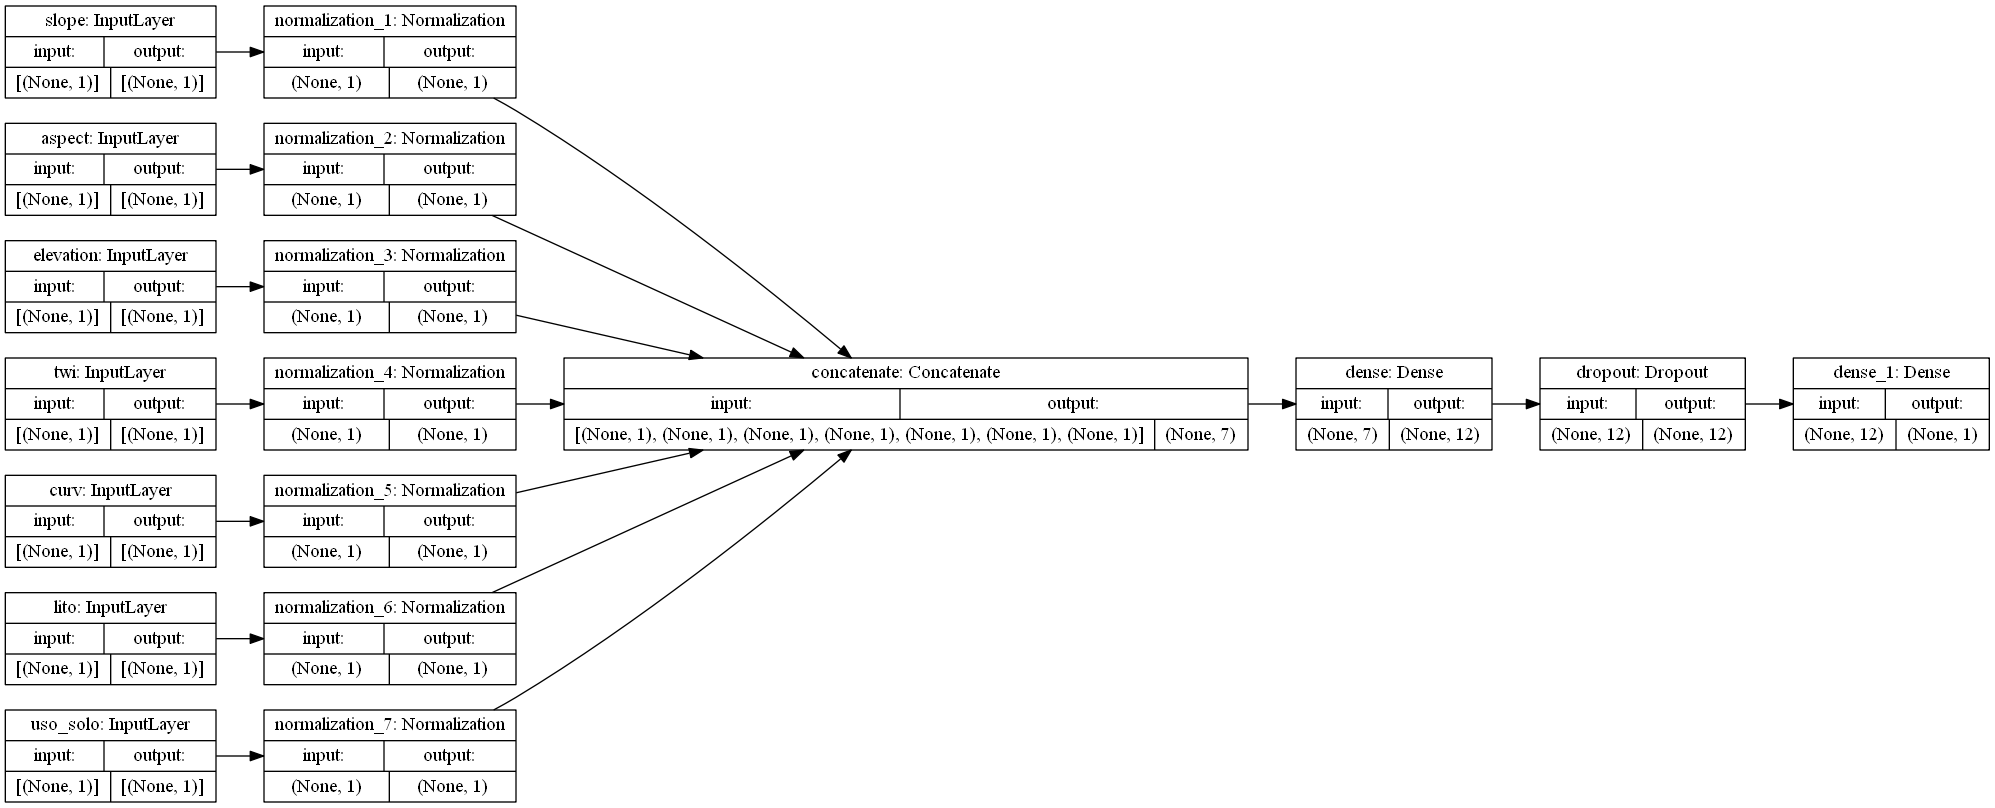

In [33]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [34]:
hypermodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
slope (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
aspect (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
elevation (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
twi (InputLayer)                [(None, 1)]          0                                            
______________________________________________________________________________________________

In [35]:
history           = hypermodel.fit(train_ds, epochs=500, validation_data=val_ds)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 1s 15ms/step - loss: 0.8463 - accuracy: 0.5938 - val_loss: 0.8382 - val_accuracy: 0.5000
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8842 - accuracy: 0.6042 - val_loss: 0.8315 - val_accuracy: 0.4762
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7370 - accuracy: 0.6042 - val_loss: 0.8263 - val_accuracy: 0.4524
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 0.8089 - accuracy: 0.6562 - val_loss: 0.8206 - val_accuracy: 0.4524
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7656 - accuracy: 0.5938 - val_loss: 0.8150 - val_accuracy: 0.4524
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7336 - accuracy: 0.6354 - val_loss: 0.8089 - val_accuracy: 0.4524
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.7788 - accuracy: 0.5729 - val_loss: 0.8042 - val_accuracy: 0.4524
Epoch 8/500


Epoch 59/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5987 - accuracy: 0.6875 - val_loss: 0.6497 - val_accuracy: 0.5476
Epoch 60/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5902 - accuracy: 0.6875 - val_loss: 0.6487 - val_accuracy: 0.5476
Epoch 61/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6188 - accuracy: 0.6979 - val_loss: 0.6469 - val_accuracy: 0.5476
Epoch 62/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.6979 - val_loss: 0.6441 - val_accuracy: 0.5714
Epoch 63/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5779 - accuracy: 0.6875 - val_loss: 0.6425 - val_accuracy: 0.5714
Epoch 64/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5379 - accuracy: 0.7812 - val_loss: 0.6408 - val_accuracy: 0.5714
Epoch 65/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5247 - accuracy: 0.7188 - val_loss: 0.6398 - val_accuracy: 0.5714
Epoch 

20/20 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.7917 - val_loss: 0.5713 - val_accuracy: 0.5952
Epoch 117/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4894 - accuracy: 0.7708 - val_loss: 0.5701 - val_accuracy: 0.5952
Epoch 118/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.7083 - val_loss: 0.5690 - val_accuracy: 0.5952
Epoch 119/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7708 - val_loss: 0.5683 - val_accuracy: 0.5952
Epoch 120/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5150 - accuracy: 0.7188 - val_loss: 0.5673 - val_accuracy: 0.5952
Epoch 121/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4534 - accuracy: 0.7604 - val_loss: 0.5665 - val_accuracy: 0.5952
Epoch 122/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4945 - accuracy: 0.6979 - val_loss: 0.5653 - val_accuracy: 0.5952
Epoch 123/500

20/20 [==============================] - 0s 2ms/step - loss: 0.4107 - accuracy: 0.7604 - val_loss: 0.5277 - val_accuracy: 0.6429
Epoch 174/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4199 - accuracy: 0.7708 - val_loss: 0.5274 - val_accuracy: 0.6429
Epoch 175/500
20/20 [==============================] - 0s 2ms/step - loss: 0.5115 - accuracy: 0.7292 - val_loss: 0.5270 - val_accuracy: 0.6429
Epoch 176/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3915 - accuracy: 0.8021 - val_loss: 0.5258 - val_accuracy: 0.6429
Epoch 177/500
20/20 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.7604 - val_loss: 0.5254 - val_accuracy: 0.6429
Epoch 178/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4564 - accuracy: 0.8021 - val_loss: 0.5247 - val_accuracy: 0.6429
Epoch 179/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.7604 - val_loss: 0.5241 - val_accuracy: 0.6429
Epoch 180/500

20/20 [==============================] - 0s 2ms/step - loss: 0.3957 - accuracy: 0.8438 - val_loss: 0.4960 - val_accuracy: 0.6905
Epoch 231/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3484 - accuracy: 0.8646 - val_loss: 0.4958 - val_accuracy: 0.6905
Epoch 232/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8125 - val_loss: 0.4952 - val_accuracy: 0.6905
Epoch 233/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3659 - accuracy: 0.8125 - val_loss: 0.4948 - val_accuracy: 0.6905
Epoch 234/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.7917 - val_loss: 0.4943 - val_accuracy: 0.6905
Epoch 235/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4155 - accuracy: 0.7812 - val_loss: 0.4937 - val_accuracy: 0.6905
Epoch 236/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3219 - accuracy: 0.8750 - val_loss: 0.4933 - val_accuracy: 0.6905
Epoch 237/500

20/20 [==============================] - 0s 2ms/step - loss: 0.3595 - accuracy: 0.8021 - val_loss: 0.4710 - val_accuracy: 0.6905
Epoch 288/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3924 - accuracy: 0.7917 - val_loss: 0.4696 - val_accuracy: 0.6905
Epoch 289/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.8229 - val_loss: 0.4697 - val_accuracy: 0.6905
Epoch 290/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4037 - accuracy: 0.8333 - val_loss: 0.4694 - val_accuracy: 0.6905
Epoch 291/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3798 - accuracy: 0.7604 - val_loss: 0.4689 - val_accuracy: 0.6905
Epoch 292/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3668 - accuracy: 0.8021 - val_loss: 0.4683 - val_accuracy: 0.6905
Epoch 293/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3581 - accuracy: 0.8021 - val_loss: 0.4681 - val_accuracy: 0.7143
Epoch 294/500

20/20 [==============================] - 0s 2ms/step - loss: 0.3228 - accuracy: 0.8333 - val_loss: 0.4489 - val_accuracy: 0.7381
Epoch 345/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.7917 - val_loss: 0.4481 - val_accuracy: 0.7381
Epoch 346/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8542 - val_loss: 0.4477 - val_accuracy: 0.7381
Epoch 347/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8125 - val_loss: 0.4475 - val_accuracy: 0.7381
Epoch 348/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3692 - accuracy: 0.7812 - val_loss: 0.4474 - val_accuracy: 0.7381
Epoch 349/500
20/20 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.7500 - val_loss: 0.4472 - val_accuracy: 0.7381
Epoch 350/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.7812 - val_loss: 0.4467 - val_accuracy: 0.7381
Epoch 351/500

20/20 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8333 - val_loss: 0.4313 - val_accuracy: 0.7619
Epoch 402/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3710 - accuracy: 0.8125 - val_loss: 0.4309 - val_accuracy: 0.7619
Epoch 403/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3942 - accuracy: 0.7708 - val_loss: 0.4308 - val_accuracy: 0.7619
Epoch 404/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.8021 - val_loss: 0.4306 - val_accuracy: 0.7619
Epoch 405/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3897 - accuracy: 0.8021 - val_loss: 0.4303 - val_accuracy: 0.7619
Epoch 406/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3526 - accuracy: 0.8125 - val_loss: 0.4302 - val_accuracy: 0.7619
Epoch 407/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8021 - val_loss: 0.4300 - val_accuracy: 0.7619
Epoch 408/500

20/20 [==============================] - 0s 2ms/step - loss: 0.2994 - accuracy: 0.8229 - val_loss: 0.4174 - val_accuracy: 0.7619
Epoch 459/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3044 - accuracy: 0.8542 - val_loss: 0.4168 - val_accuracy: 0.7619
Epoch 460/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3196 - accuracy: 0.8438 - val_loss: 0.4163 - val_accuracy: 0.7619
Epoch 461/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3284 - accuracy: 0.7917 - val_loss: 0.4159 - val_accuracy: 0.7619
Epoch 462/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.8333 - val_loss: 0.4158 - val_accuracy: 0.7619
Epoch 463/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3498 - accuracy: 0.8229 - val_loss: 0.4154 - val_accuracy: 0.7619
Epoch 464/500
20/20 [==============================] - 0s 2ms/step - loss: 0.3513 - accuracy: 0.7812 - val_loss: 0.4156 - val_accuracy: 0.7619
Epoch 465/500

In [36]:
print('Melhor epoch: %d' % (best_epoch,))

Melhor epoch: 387


In [37]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

12/12 [==============================] - 0s 1ms/step - loss: 0.4222 - accuracy: 0.8667
[test loss, test accuracy]: [0.42215695977211, 0.8666666746139526]


### Train the model

In [38]:
# Retreina o modelo
history_best = hypermodel.fit(train_ds, epochs=best_epoch, validation_data=val_ds)

Epoch 1/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3129 - accuracy: 0.8438 - val_loss: 0.4072 - val_accuracy: 0.7619
Epoch 2/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3781 - accuracy: 0.8125 - val_loss: 0.4070 - val_accuracy: 0.7619
Epoch 3/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3646 - accuracy: 0.8542 - val_loss: 0.4075 - val_accuracy: 0.7619
Epoch 4/387
20/20 [==============================] - 0s 3ms/step - loss: 0.3318 - accuracy: 0.8542 - val_loss: 0.4074 - val_accuracy: 0.7619
Epoch 5/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8542 - val_loss: 0.4074 - val_accuracy: 0.7619
Epoch 6/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3288 - accuracy: 0.8958 - val_loss: 0.4073 - val_accuracy: 0.7619
Epoch 7/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.7500 - val_loss: 0.4069 - val_accuracy: 0.7619
Epoch 8/387
2

Epoch 59/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3198 - accuracy: 0.8125 - val_loss: 0.3921 - val_accuracy: 0.7619
Epoch 60/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3375 - accuracy: 0.8438 - val_loss: 0.3921 - val_accuracy: 0.7619
Epoch 61/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3263 - accuracy: 0.8438 - val_loss: 0.3920 - val_accuracy: 0.7619
Epoch 62/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2997 - accuracy: 0.8021 - val_loss: 0.3919 - val_accuracy: 0.7619
Epoch 63/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3004 - accuracy: 0.8438 - val_loss: 0.3922 - val_accuracy: 0.7619
Epoch 64/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3336 - accuracy: 0.8333 - val_loss: 0.3919 - val_accuracy: 0.7619
Epoch 65/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3773 - accuracy: 0.7708 - val_loss: 0.3917 - val_accuracy: 0.7619
Epoch 

20/20 [==============================] - 0s 2ms/step - loss: 0.3336 - accuracy: 0.8021 - val_loss: 0.3913 - val_accuracy: 0.7619
Epoch 117/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.8750 - val_loss: 0.3916 - val_accuracy: 0.7619
Epoch 118/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3328 - accuracy: 0.8438 - val_loss: 0.3916 - val_accuracy: 0.7619
Epoch 119/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2926 - accuracy: 0.8646 - val_loss: 0.3914 - val_accuracy: 0.7619
Epoch 120/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3275 - accuracy: 0.8333 - val_loss: 0.3913 - val_accuracy: 0.7619
Epoch 121/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2939 - accuracy: 0.8646 - val_loss: 0.3914 - val_accuracy: 0.7619
Epoch 122/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3112 - accuracy: 0.8125 - val_loss: 0.3915 - val_accuracy: 0.7619
Epoch 123/387

20/20 [==============================] - 0s 2ms/step - loss: 0.3172 - accuracy: 0.8854 - val_loss: 0.3905 - val_accuracy: 0.7619
Epoch 174/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2874 - accuracy: 0.8854 - val_loss: 0.3905 - val_accuracy: 0.7619
Epoch 175/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8333 - val_loss: 0.3895 - val_accuracy: 0.7619
Epoch 176/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3152 - accuracy: 0.8542 - val_loss: 0.3892 - val_accuracy: 0.7619
Epoch 177/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3075 - accuracy: 0.8750 - val_loss: 0.3889 - val_accuracy: 0.7619
Epoch 178/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3316 - accuracy: 0.8646 - val_loss: 0.3891 - val_accuracy: 0.7619
Epoch 179/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3055 - accuracy: 0.8854 - val_loss: 0.3889 - val_accuracy: 0.7619
Epoch 180/387

20/20 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8750 - val_loss: 0.3881 - val_accuracy: 0.7619
Epoch 231/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2907 - accuracy: 0.8958 - val_loss: 0.3878 - val_accuracy: 0.7619
Epoch 232/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3201 - accuracy: 0.8125 - val_loss: 0.3876 - val_accuracy: 0.7619
Epoch 233/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.8333 - val_loss: 0.3876 - val_accuracy: 0.7619
Epoch 234/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.8646 - val_loss: 0.3878 - val_accuracy: 0.7619
Epoch 235/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3223 - accuracy: 0.8750 - val_loss: 0.3878 - val_accuracy: 0.7619
Epoch 236/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2610 - accuracy: 0.8646 - val_loss: 0.3881 - val_accuracy: 0.7619
Epoch 237/387

20/20 [==============================] - 0s 2ms/step - loss: 0.2785 - accuracy: 0.8958 - val_loss: 0.3851 - val_accuracy: 0.7857
Epoch 288/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3212 - accuracy: 0.8333 - val_loss: 0.3854 - val_accuracy: 0.7857
Epoch 289/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2460 - accuracy: 0.8646 - val_loss: 0.3854 - val_accuracy: 0.7857
Epoch 290/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.8229 - val_loss: 0.3850 - val_accuracy: 0.7857
Epoch 291/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8333 - val_loss: 0.3850 - val_accuracy: 0.7857
Epoch 292/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3143 - accuracy: 0.8021 - val_loss: 0.3859 - val_accuracy: 0.7857
Epoch 293/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3065 - accuracy: 0.8125 - val_loss: 0.3857 - val_accuracy: 0.7857
Epoch 294/387

20/20 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.8958 - val_loss: 0.3854 - val_accuracy: 0.7857
Epoch 345/387
20/20 [==============================] - 0s 2ms/step - loss: 0.2570 - accuracy: 0.8750 - val_loss: 0.3855 - val_accuracy: 0.7857
Epoch 346/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8646 - val_loss: 0.3858 - val_accuracy: 0.7857
Epoch 347/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8438 - val_loss: 0.3858 - val_accuracy: 0.7857
Epoch 348/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3051 - accuracy: 0.8542 - val_loss: 0.3859 - val_accuracy: 0.7857
Epoch 349/387
20/20 [==============================] - 0s 3ms/step - loss: 0.3040 - accuracy: 0.8542 - val_loss: 0.3858 - val_accuracy: 0.7857
Epoch 350/387
20/20 [==============================] - 0s 2ms/step - loss: 0.3108 - accuracy: 0.8646 - val_loss: 0.3861 - val_accuracy: 0.7857
Epoch 351/387

In [39]:
eval_result = hypermodel.evaluate(test_ds)
print("[test loss, test accuracy]:", eval_result)

12/12 [==============================] - 0s 1ms/step - loss: 0.4167 - accuracy: 0.8833
[test loss, test accuracy]: [0.41669854521751404, 0.8833333253860474]


In [40]:
eval_result = hypermodel.evaluate(val_ds)
print("[val loss, val accuracy]:", eval_result)

9/9 [==============================] - 0s 1ms/step - loss: 0.3876 - accuracy: 0.7857
[val loss, val accuracy]: [0.3876420855522156, 0.7857142686843872]


In [41]:
batch_size = 5
full_ds = df_to_dataset(dataframe, batch_size=batch_size)
eval_result = hypermodel.evaluate(full_ds)
print("[full dataset loss, full dataset accuracy]:", eval_result)

40/40 [==============================] - 0s 1ms/step - loss: 0.3200 - accuracy: 0.8737
[full dataset loss, full dataset accuracy]: [0.31999459862709045, 0.8737373948097229]


# Avaliação do modelo ao longo do tempo de treinamento

Teste: 0.874


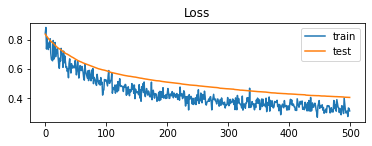

In [42]:
from matplotlib import pyplot
print('Teste: %.3f' % (eval_result[1]))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

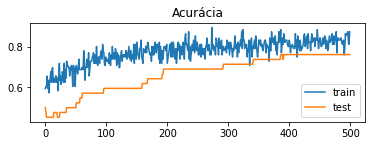

In [43]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Acurácia')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

#### __Métricas do hypermodel__

ref. https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

## Inferência de dados novos

Key point: O modelo otimizado pode classificar um conjunto de linhas de um arquivo CSV, visto que o código de preprocessamento é incluso no modelo em si.


É possível salvar e reutilizar o modelo keras. Para mais informações, [aqui](https://www.tensorflow.org/tutorials/keras/save_and_load).

In [44]:
hypermodel.save('landslides')

INFO:tensorflow:Assets written to: landslides\assets


In [45]:
reloaded_model = tf.keras.models.load_model('landslides')

Para predição de um ponto de escorregamento, utilizar o método `model.predict()`. Necessário obdecer duas condições:

1.   Envolva os escalares em uma lista para ter uma dimensão de lote (os modelos processam apenas lotes de dados, não amostras únicas)
2.   Evocar o método `convert_to_tensor` para cada feature

In [46]:
sample1 = {
    'slope': 11.090160,
    'aspect': 178.25730,
    'elevation': 68.48230,
    'uso_solo': 1210,
    'lito': 2742,
    'twi': 7.579783,
    'curv': -0.000890,
}

sample2 = {
    'slope': 35.92639,
    'aspect': 355.0102,
    'elevation': 126.454,
    'uso_solo': 2230,
    'lito': 2741,
    'twi': 5.942304134,
    'curv': 0.001232411,
}

sample3 = {
    'slope': 16.2957,
    'aspect': 216.5744,
    'elevation': 106.033,
    'uso_solo': 2230,
    'lito': 2773,
    'twi': 9.18202877,
    'curv': -0.0158732,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample2.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "A localização com essas características tem %.1f porcento de probabilidade de escoregamento "
     % (100 * prob)
)

A localização com essas características tem 100.0 porcento de probabilidade de escoregamento 


Normalmente temos melhores resultados em deep learning com maiores e mais complexos conjuntos de dados. Ao trabalhar com um pequeno conjunto de dados como este, recomendamos o uso de uma decision tree ou random forest como uma linha de base forte. O objetivo deste tutorial é demonstrar a mecânica de trabalhar com dados estruturados, para que você tenha o código para usar como ponto de partida ao trabalhar com seus próprios datasets no futuro.